#STEP 1: Setup and Dataset Downloading from Google Drive

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='archive.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('archive.zip')
!unzip 'archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

#STEP 2: Importing Required Libraries

In [3]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

print(tf.__version__)

2.18.0


#STEP 3: Data Preprocessing

In [6]:
image_size = 224
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(
    '/content/PlantVillage/train',
    shuffle=True,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='training',
    seed=66
)

validation_dataset = train_datagen.flow_from_directory(
    '/content/PlantVillage/val',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='validation',
    seed=66,
    shuffle=False
)

Found 34771 images belonging to 38 classes.
Found 2160 images belonging to 38 classes.


#STEP 4: Model Architecture

In [7]:
input_shape = (image_size, image_size, 3)
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_dataset.class_indices), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#STEP 5: Model Summary

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,599,142 (21.36 MB)

 Trainable params: 5,599,142 (21.36 MB)

 Non-trainable params: 0 (0.00 B)

#STEP 6: Compile Model

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-4),
    metrics=['acc']
)

#STEP 7: Model Training
First Section is To Get Better Accuracy On Entire Dataset. As Of Now Its Set To Test On Small Sample Data

In [11]:
# history = model.fit(
#     train_dataset,
#     epochs=3,
#     validation_data=validation_dataset
# )

history = model.fit(
    train_dataset,
    epochs=1,
    steps_per_epoch=3,
    validation_data=validation_dataset,
    validation_steps=1
)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - acc: 0.7229 - loss: 1.0271 - val_acc: 0.2000 - val_loss: 2.5877


#STEP 8: Accuracy and Loss Graphs

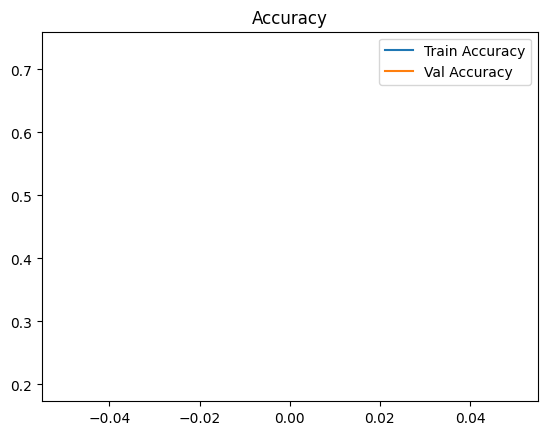

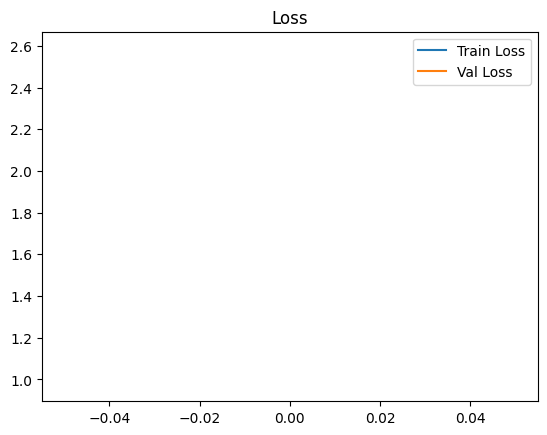

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

#STEP 9: Model Evaluation

In [13]:
test_acc = model.evaluate(validation_dataset, verbose=0)[1]
train_acc = model.evaluate(train_dataset, verbose=0)[1]
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Train Accuracy: {train_acc*100:.2f}%")

Test Accuracy: 73.70%
Train Accuracy: 74.60%


#STEP 10: Confusion Matrix

108/108 ━━━━━━━━━━━━━━━━━━━━ 61s 553ms/step


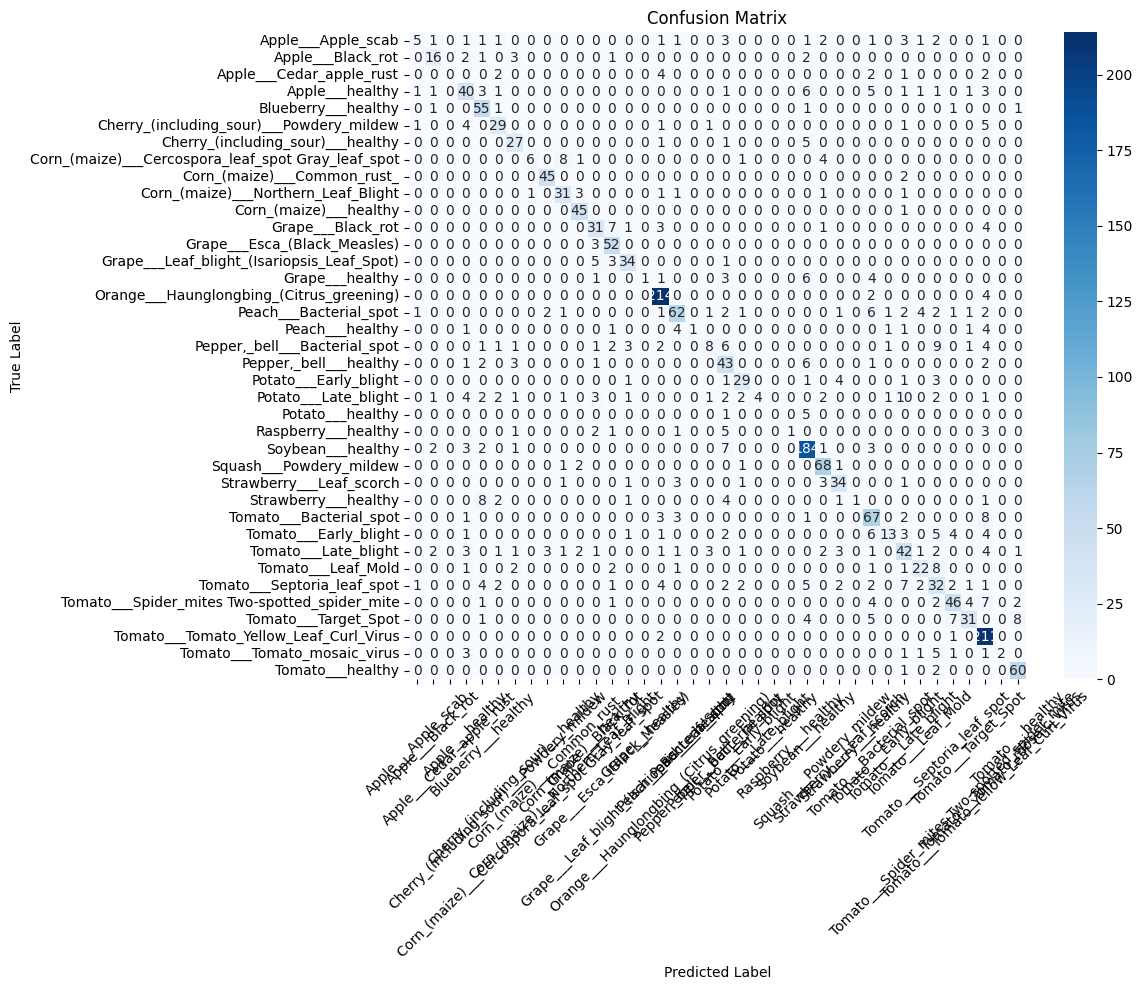

In [14]:
class_names = list(validation_dataset.class_indices.keys())
validation_dataset.reset()
predictions = model.predict(validation_dataset, verbose=1)
true_labels = validation_dataset.classes
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#STEP 11: Metrics (F1, Precision, Recall, ROC-AUC)

In [15]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

true_labels_one_hot = np.eye(len(np.unique(true_labels)))[true_labels]
roc_auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

F1 Score: 0.7095
Precision: 0.7441
Recall: 0.7370
ROC-AUC Score: 0.9744


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#STEP 12: Multi-class ROC Curve

<ipython-input-16-bb3208bbaee8>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


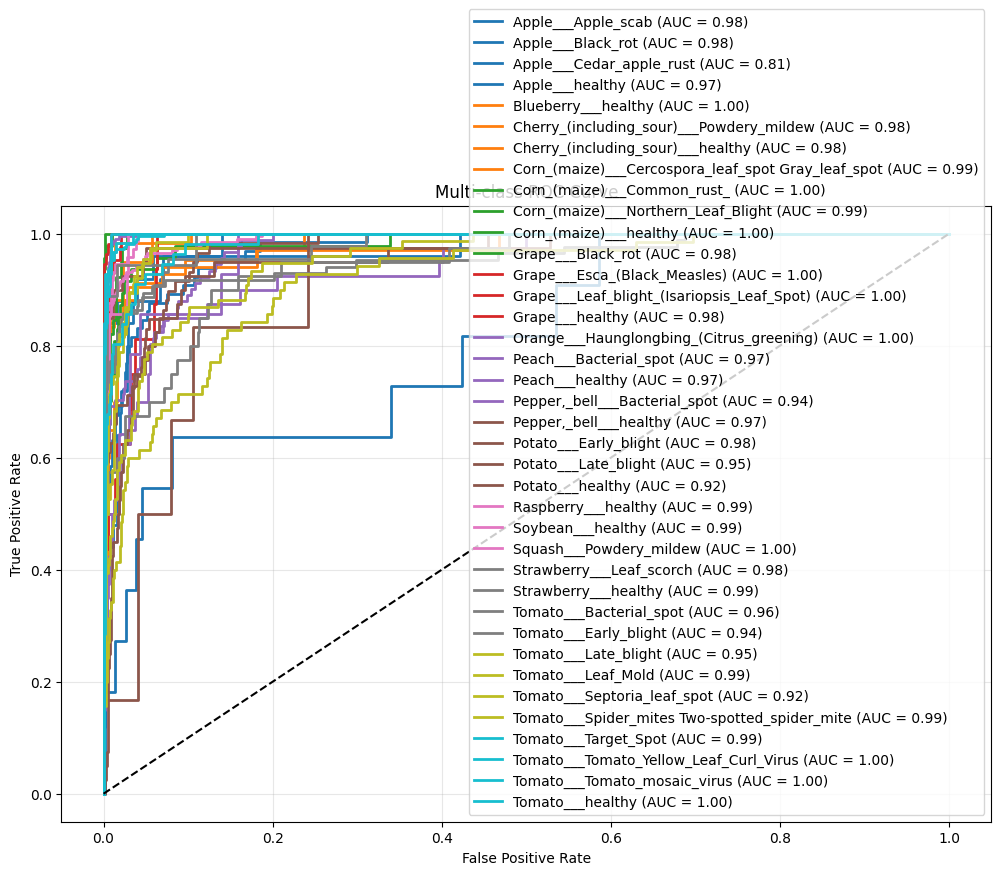

In [16]:
n_classes = len(class_names)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc_curve = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc_curve[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors(i), label=f'{class_names[i]} (AUC = {roc_auc_curve[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()